In [4]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8")





In [17]:
df = pd.read_csv("C:/Python/New_Files/us_treasury_yield_curve.csv",index_col=0) 
df = df.sort_index()
df.head()

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,30Y
01-01-2010,0.203974,0.298894,0.405182,0.612184,0.998127,1.298127,1.712634,1.906139,2.196244,2.704340
01-01-2011,0.292259,0.385593,0.409249,0.651024,1.098764,1.387100,1.519686,1.861058,2.350964,3.090360
01-01-2012,0.324868,0.303213,0.400519,0.343563,0.946893,1.131632,1.546550,1.843716,2.135309,2.950115
01-01-2013,0.275057,0.540933,0.123629,0.121649,1.101683,1.001590,1.621500,1.859250,2.024614,3.090482
01-01-2014,0.407236,0.470061,0.057222,0.226408,1.139050,1.202936,1.894159,1.760392,2.133171,3.069016


In [18]:
# Calculating Daily Changes in Yield Curve

In [20]:
df = df.apply(pd.to_numeric, errors='coerce')
df_returns = df.diff().dropna()
df_returns.head()
              

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,30Y
01-01-2011,0.088285,0.086699,0.004067,0.038840,0.100637,0.088973,-0.192948,-0.045082,0.154720,0.386020
01-01-2012,0.032609,-0.082381,-0.008730,-0.307461,-0.151871,-0.255468,0.026864,-0.017342,-0.215655,-0.140246
01-01-2013,-0.049811,0.237720,-0.276890,-0.221915,0.154791,-0.130042,0.074951,0.015534,-0.110694,0.140368
01-01-2014,0.132180,-0.070872,-0.066407,0.104760,0.037367,0.201346,0.272658,-0.098857,0.108556,-0.021466
01-01-2015,0.018171,0.203835,-0.090233,0.109939,-0.025615,0.242742,0.158205,0.079194,-0.025965,0.026912


In [21]:
# Performing PCA on yield changes

In [22]:

pca = PCA(n_components=3)
pca.fit(df_returns)

explained_var = pca.explained_variance_ratio_

print("Variance Explained by PCA Factors:")
for i, var in enumerate(explained_var, 1):
    print(f"Factor {i}: {var:.2%}")


Variance Explained by PCA Factors:
Factor 1: 50.22%
Factor 2: 12.06%
Factor 3: 9.80%


In [23]:
# PCA factor Loadings

In [24]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=df.columns,
    columns=["Level", "Slope", "Curvature"]
)

loadings

,Level,Slope,Curvature
1M,0.203594,-0.134448,0.426904
3M,-0.099762,0.638198,0.380924
6M,-0.465382,-0.260887,-0.164732
1Y,-0.374923,-0.395379,0.055944
2Y,-0.022052,-0.151012,0.249808
3Y,-0.046294,-0.490959,0.395697
5Y,0.752456,-0.247982,-0.073916
7Y,-0.103642,0.124196,0.431355
10Y,0.062747,-0.096841,0.468673
30Y,-0.089172,-0.009834,0.110537


In [28]:

# MONTE CARLO SIMULATION OF YIELD CURVES


num_sims = 1000       # number of simulations
horizon = 30          # days ahead to simulate

# PCA factor volatilities
factor_vol = df_returns @ pca.components_.T
factor_cov = np.cov(factor_vol.T)

# initial yield curve
y0 = df.iloc[-1].values

simulated_curves = []

for i in range(num_sims):
    curve = y0.copy()
    for t in range(horizon):
        # simulate PCA factor shocks
        shock = np.random.multivariate_normal(mean=np.zeros(3), cov=factor_cov)
        delta_yield = shock @ pca.components_
        curve = curve + delta_yield
    simulated_curves.append(curve)

simulated_curves = np.array(simulated_curves)
pd.DataFrame(simulated_curves[:, :5]).head()

,0,1,2,3,4
0,-0.214758,-1.265504,1.743839,1.948737,1.062414
1,0.630093,-0.537591,0.689585,1.276259,1.312360
2,-0.676870,0.366396,1.964872,1.824202,0.893005
3,0.537632,0.113406,-0.575459,-0.176679,0.854767
4,0.432877,-0.939783,-0.760995,-0.382206,0.677252


In [29]:
#  PLOT – SIMULATED YIELD CURVES

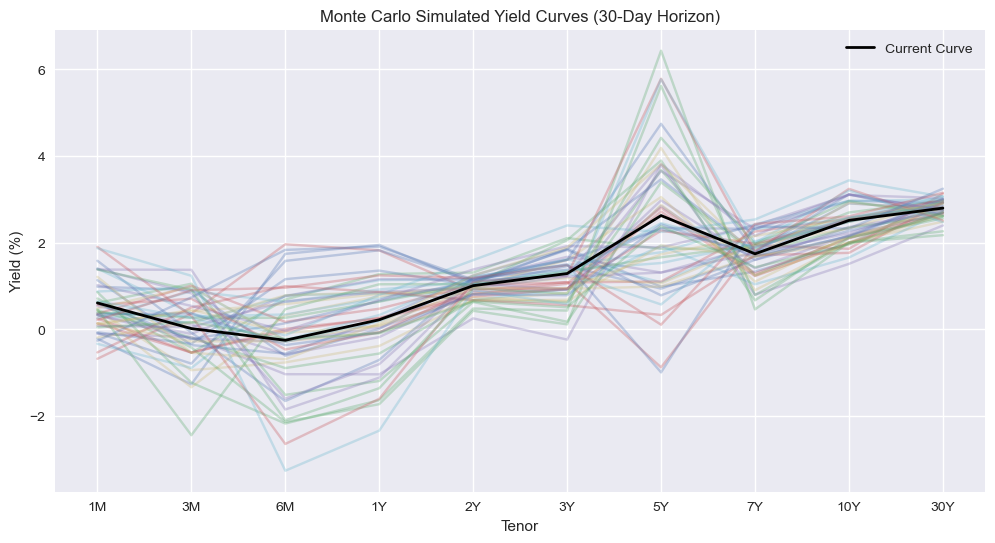

In [30]:
plt.figure(figsize=(12,6))
for i in range(50):  # plot 50 random simulations
    plt.plot(df.columns, simulated_curves[i], alpha=0.3)

plt.plot(df.columns, y0, color="black", linewidth=2, label="Current Curve")
plt.title("Monte Carlo Simulated Yield Curves (30-Day Horizon)")
plt.xlabel("Tenor")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#  PLOT PCA LOADINGS — SHAPE OF FACTORS

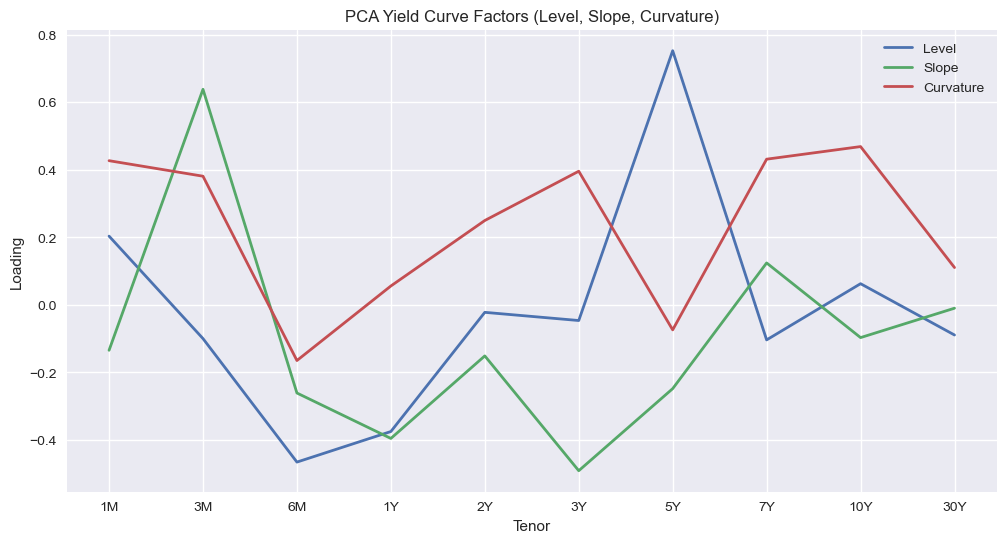

In [32]:
plt.figure(figsize=(12,6))
for col in loadings.columns:
    plt.plot(loadings.index, loadings[col], label=col, linewidth=2)

plt.title("PCA Yield Curve Factors (Level, Slope, Curvature)")
plt.xlabel("Tenor")
plt.ylabel("Loading")
plt.legend()
plt.grid(True)
plt.show()